## Outlier

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'white'
from datetime import datetime, timedelta



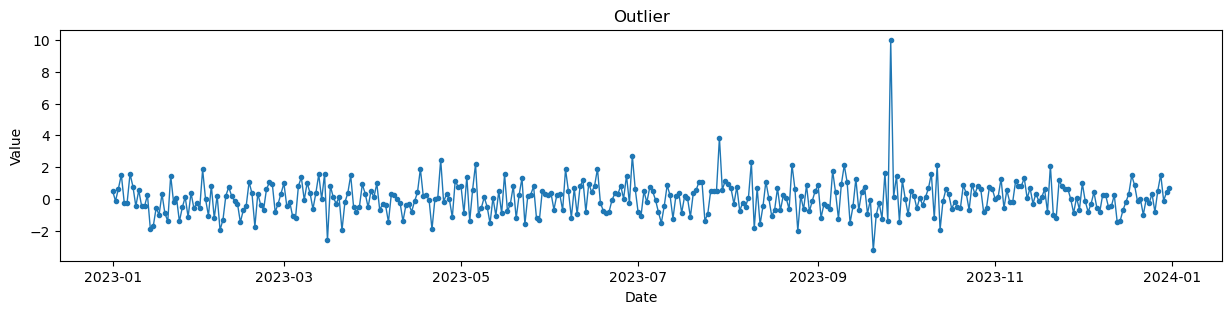

In [2]:
# 生成日期范围
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 31)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# 生成每天的随机数据
np.random.seed(42)
data_values = np.random.normal(size=len(date_range))

# 将2023.09.26这一天的数据设置为离群值
outlier_date = datetime(2023, 9, 26)
outlier_index = date_range.get_loc(outlier_date)
data_values[outlier_index] = 10  # 设置为一个较大的离群值

# 创建数据框
df = pd.DataFrame({'Date': date_range, 'Value': data_values})

# 绘制点线图
plt.figure(figsize=(15, 3))


plt.plot(df['Date'], df['Value'], marker='o', markersize=3, linestyle='-', linewidth=1)
plt.title('Outlier', color='black')
plt.xlabel('Date', color='black')
plt.ylabel('Value', color='black')


plt.show()


## Spike

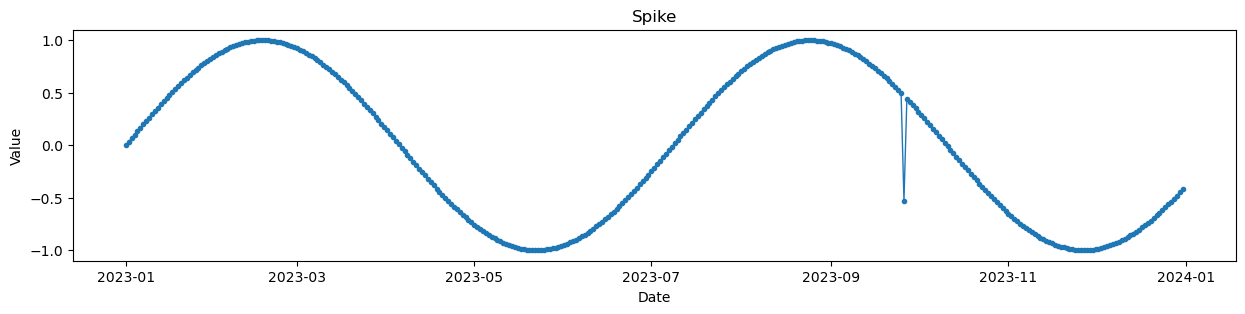

In [3]:

# 生成日期范围
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 31)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# 生成每天的sin函数数据
sin_values = np.sin(np.arange(len(date_range)) / 30)  # 调整周期，这里假设一个月为一个周期

# 在2023.09.26这一天添加尖峰
peak_date = datetime(2023, 9, 26)
peak_index = date_range.get_loc(peak_date)
sin_values[peak_index] -= 1  # 添加尖峰

# 创建数据框
df = pd.DataFrame({'Date': date_range, 'Value': sin_values})

# 绘制点线图
plt.figure(figsize=(15, 3))
plt.plot(df['Date'], df['Value'], marker='o', markersize=3, linestyle='-', linewidth=1)
plt.title('Spike')
plt.xlabel('Date')
plt.ylabel('Value')

plt.show()


In [4]:
df = df.set_index('Date')['Value']
df

Date
2023-01-01    0.000000
2023-01-02    0.033327
2023-01-03    0.066617
2023-01-04    0.099833
2023-01-05    0.132939
                ...   
2023-12-27   -0.536573
2023-12-28   -0.508152
2023-12-29   -0.479166
2023-12-30   -0.449647
2023-12-31   -0.419630
Name: Value, Length: 365, dtype: float64

In [5]:
from src.adtk.data._data import validate_series
s = validate_series(df)

D:\company\project\anomaly_detection_point\src\adtk\transformer\_transformer_1d.py:285: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  s_rolling = rolling.agg(agg)


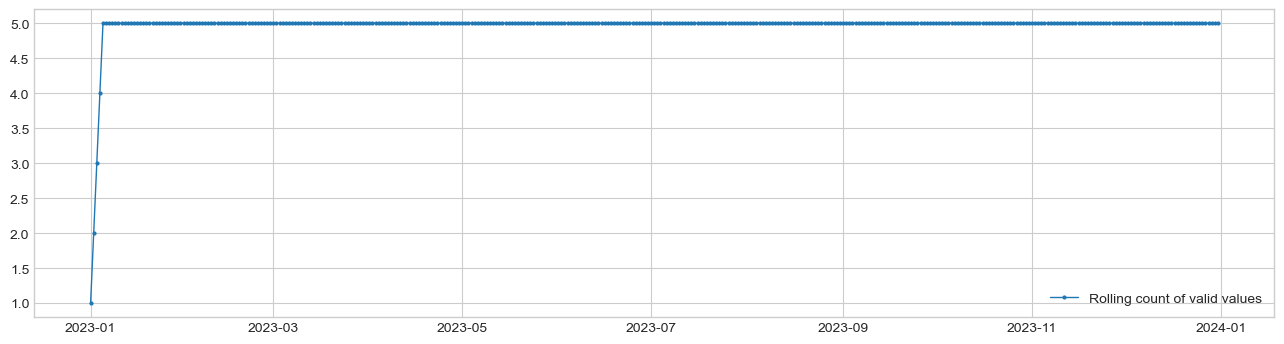

In [6]:
from src.adtk.transformer import RollingAggregate
from src.adtk.visualization._visualization import plot
s_transformed = RollingAggregate(agg='count', window=5).transform(s)
plot(s_transformed.rename("Rolling count of valid values"), ts_linewidth=1, ts_markersize=4);

## Level Shift

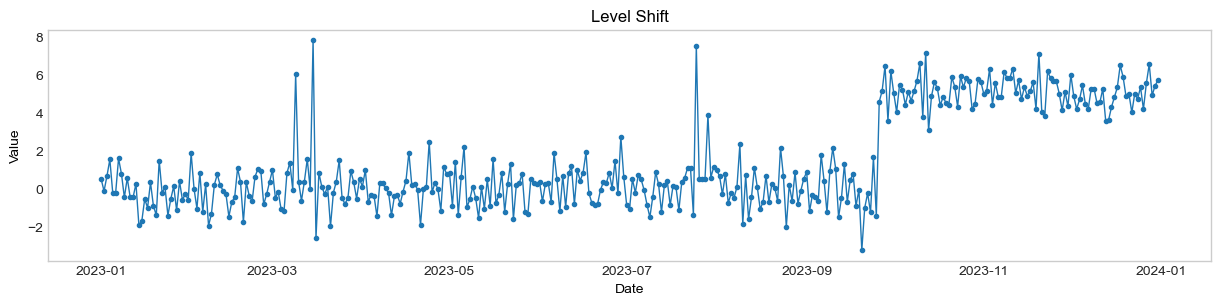

In [68]:

# 生成日期范围
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 31)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# 生成每天的随机数据
np.random.seed(42)
data_values = np.random.normal(size=len(date_range))

# 在2023.09.26这一天发生Level Shift异常
shift_date = datetime(2023, 9, 26)
shift_index = date_range.get_loc(shift_date)
data_values[shift_index:] += 5  # Level Shift异常

# 修改特定日期的值
data_values[date_range == datetime(2023, 3, 9)] = 6
data_values[date_range == datetime(2023, 3, 15)] = 7.8
data_values[date_range == datetime(2023, 7, 25)] = 7.5

# 创建数据框
df = pd.DataFrame({'Date': date_range, 'Value': data_values})

# 绘制点线图
plt.figure(figsize=(15, 3))
plt.plot(df['Date'], df['Value'], marker='o', markersize=3, linestyle='-', linewidth=1)
plt.title('Level Shift', color='black')
plt.xlabel('Date', color='black')
plt.ylabel('Value', color='black')


plt.grid(False)
plt.show()


In [69]:
df = df.set_index('Date')['Value']
df

Date
2023-01-01    0.496714
2023-01-02   -0.138264
2023-01-03    0.647689
2023-01-04    1.523030
2023-01-05   -0.234153
                ...   
2023-12-27    5.519347
2023-12-28    6.532739
2023-12-29    4.891240
2023-12-30    5.401712
2023-12-31    5.690144
Name: Value, Length: 365, dtype: float64

In [70]:
from src.adtk.data._data import validate_series
s = validate_series(df)

In [71]:
from src.adtk.transformer import DoubleRollingAggregate
s_transformed = DoubleRollingAggregate(
    agg="median",
    window=5,
    diff="diff").transform(s).rename("Diff rolling median (mm)")
s_transformed

Date
2023-01-01         NaN
2023-01-02         NaN
2023-01-03         NaN
2023-01-04         NaN
2023-01-05         NaN
                ...   
2023-12-27    0.808005
2023-12-28         NaN
2023-12-29         NaN
2023-12-30         NaN
2023-12-31         NaN
Freq: D, Name: Diff rolling median (mm), Length: 365, dtype: float64

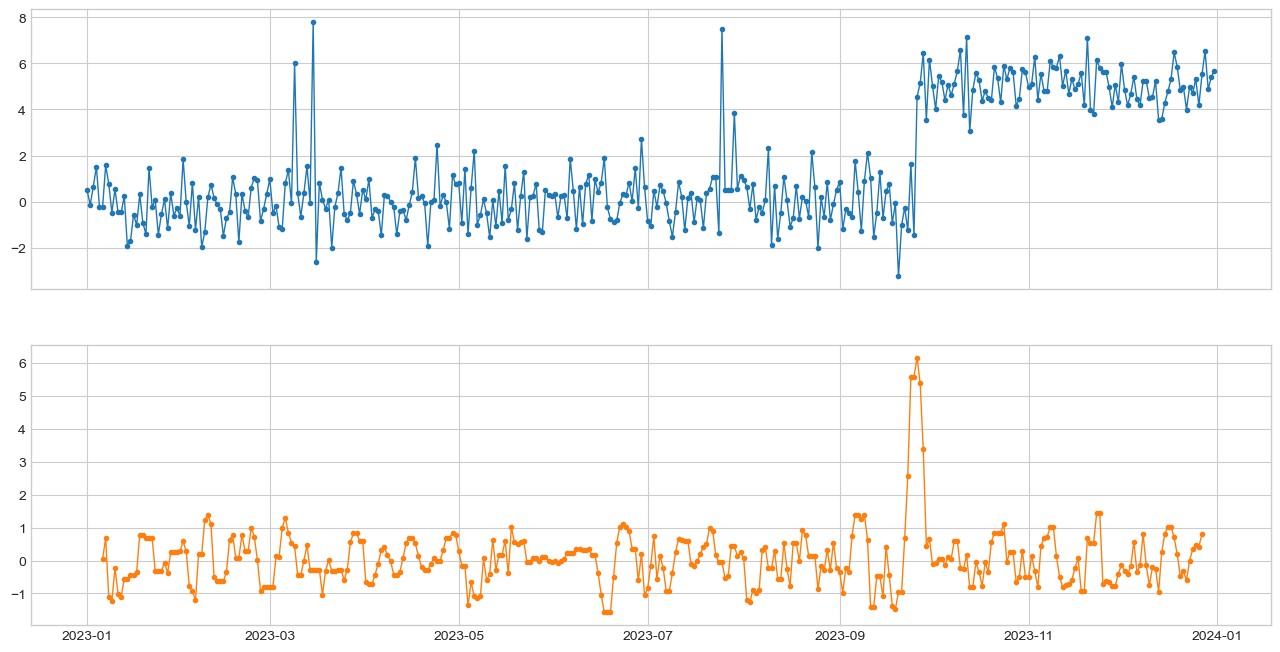

In [72]:
from src.adtk.visualization._visualization import plot
plot(pd.concat([s, s_transformed], axis=1), ts_markersize=6, ts_linewidth=1, legend=False);

D:\company\project\adtk\src\adtk\data\_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


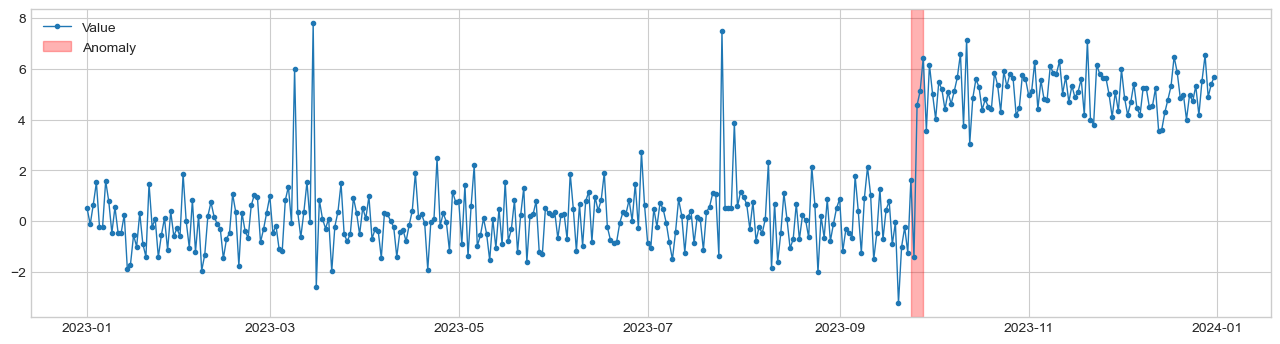

In [73]:
from src.adtk.detector import LevelShiftAD
level_shift_ad = LevelShiftAD(c=6.0, side='both', window=5)
anomalies = level_shift_ad.fit_detect(s)
plot(s, anomaly=anomalies, anomaly_color='red', ts_markersize=6, ts_linewidth=1);

## Pattern Change

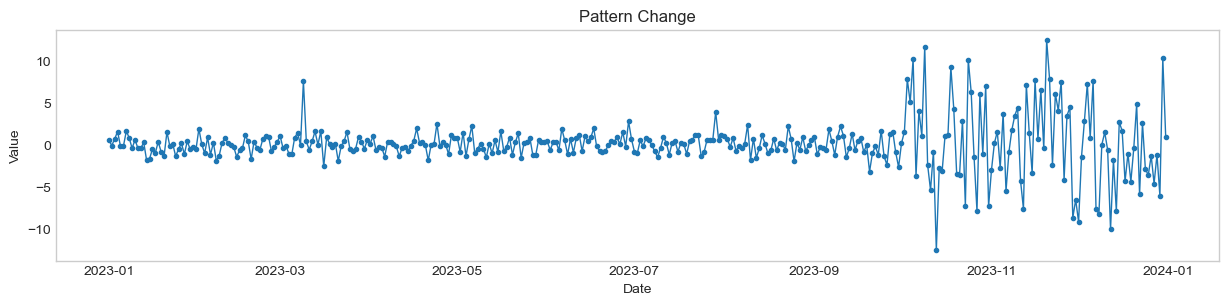

In [111]:

# 生成日期范围
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 31)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# 生成每天的随机数据
np.random.seed(42)
data_values = np.random.normal(size=len(date_range))

# 在2023.09.26这一天发生Pattern Change异常
change_date = datetime(2023, 9, 26)
change_index = date_range.get_loc(change_date)
data_values[change_index:] += np.random.normal(0, 5, len(data_values) - change_index)  # 添加随机扰动

data_values[date_range == datetime(2023, 3, 9)] = 7.5




# 创建数据框
df = pd.DataFrame({'Date': date_range, 'Value': data_values})

# 绘制点线图
plt.figure(figsize=(15, 3))
plt.plot(df['Date'], df['Value'], marker='o', markersize=3, linestyle='-', linewidth=1)
plt.title('Pattern Change')
plt.xlabel('Date')
plt.ylabel('Value')

plt.grid(False)
plt.show()


In [112]:
df = df.set_index('Date')['Value']
df

Date
2023-01-01     0.496714
2023-01-02    -0.138264
2023-01-03     0.647689
2023-01-04     1.523030
2023-01-05    -0.234153
                ...    
2023-12-27    -4.656865
2023-12-28    -1.235508
2023-12-29    -6.098150
2023-12-30    10.225337
2023-12-31     0.866462
Name: Value, Length: 365, dtype: float64

In [113]:
from src.adtk.data._data import validate_series
s = validate_series(df)

In [114]:
from src.adtk.transformer import DoubleRollingAggregate
s_transformed = DoubleRollingAggregate(
    agg="quantile",
    agg_params={"q": [0.1, 0.5, 0.9]},
    window=50,
    diff="l2").transform(s).rename("Diff rolling quantiles (mm)")
s_transformed

Date
2023-01-01   NaN
2023-01-02   NaN
2023-01-03   NaN
2023-01-04   NaN
2023-01-05   NaN
              ..
2023-12-27   NaN
2023-12-28   NaN
2023-12-29   NaN
2023-12-30   NaN
2023-12-31   NaN
Freq: D, Name: Diff rolling quantiles (mm), Length: 365, dtype: float64

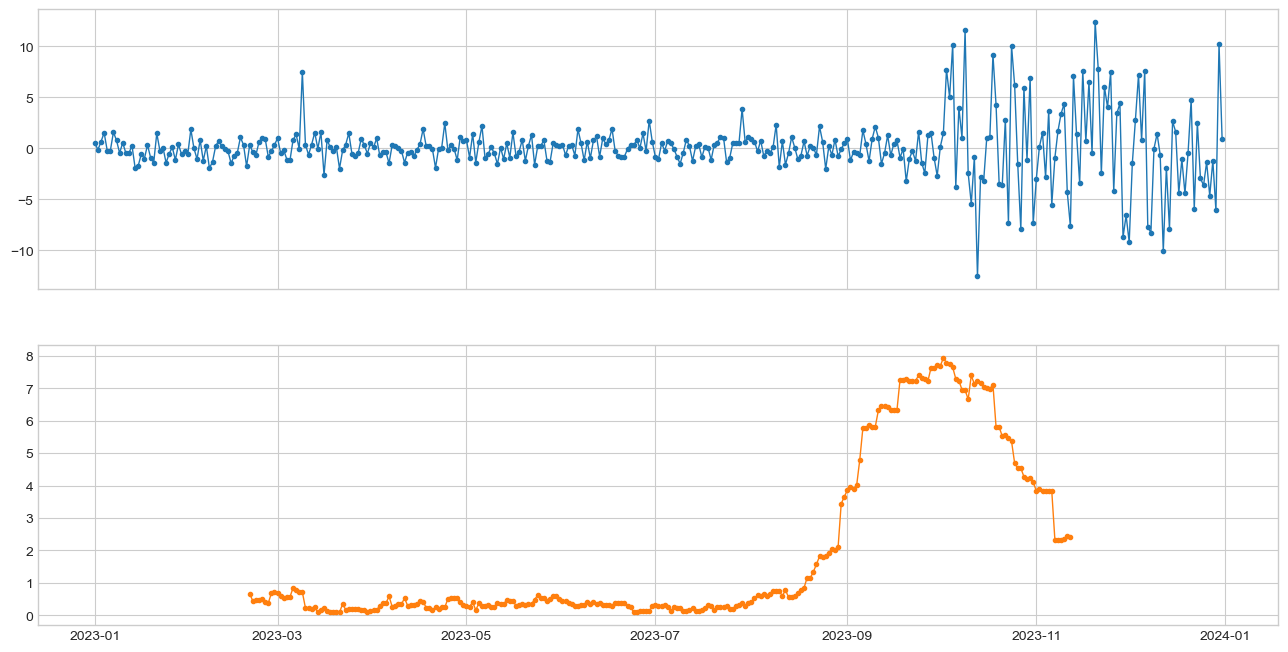

In [115]:
plot(pd.concat([s, s_transformed], axis=1), ts_markersize=6, ts_linewidth=1, legend=False);

In [116]:
from src.adtk.detector import VolatilityShiftAD
volatility_shift_ad = VolatilityShiftAD(c=6.0, side='positive', window=50)
anomalies = volatility_shift_ad.fit_detect(s)
anomalies


Date
2023-01-01    NaN
2023-01-02    NaN
2023-01-03    NaN
2023-01-04    NaN
2023-01-05    NaN
             ... 
2023-12-27    NaN
2023-12-28    NaN
2023-12-29    NaN
2023-12-30    NaN
2023-12-31    NaN
Freq: D, Name: Value, Length: 365, dtype: object

D:\company\project\adtk\src\adtk\data\_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


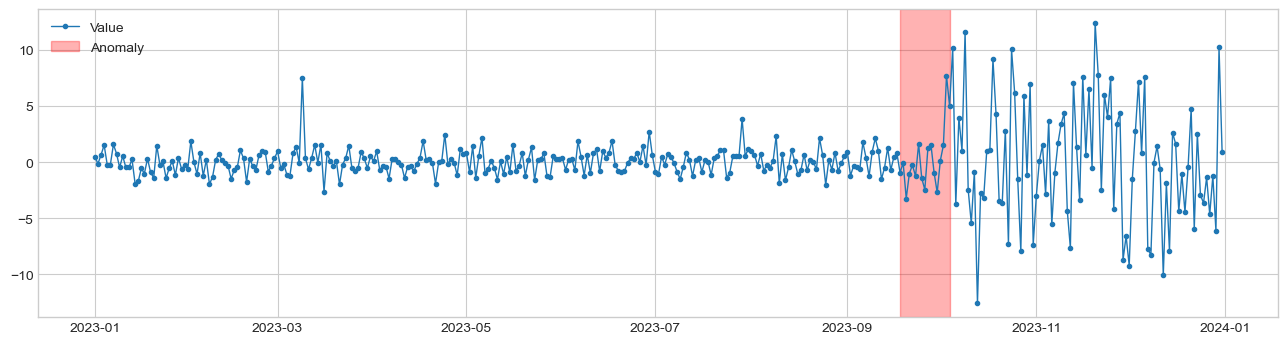

In [117]:
plot(s, anomaly=anomalies, anomaly_color='red', ts_markersize=6, ts_linewidth=1);

## Seasonality

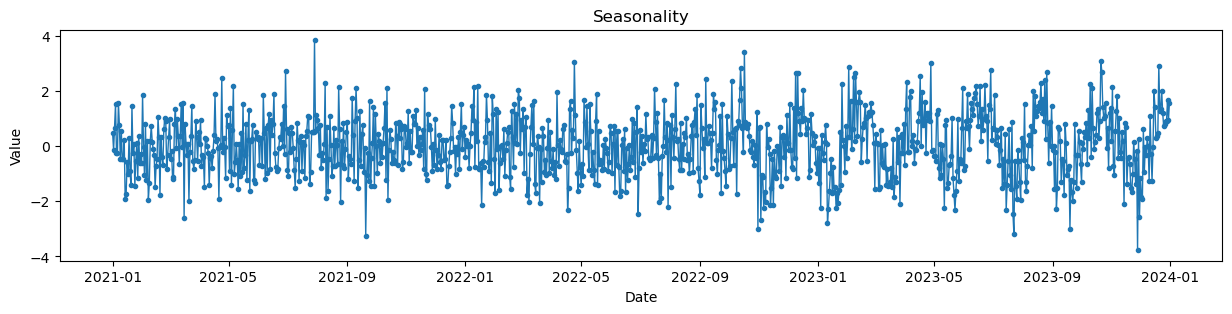

In [11]:

# 生成日期范围
start_date = datetime(2021, 1, 1)
end_date = datetime(2023, 12, 31)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# 生成每天的随机数据
np.random.seed(42)
data_values = np.random.normal(size=len(date_range))

# 在2023.09.26这一天发生Seasonality异常
seasonality_date = datetime(2022, 9, 26)
seasonality_index = date_range.get_loc(seasonality_date)
seasonal_pattern = np.sin(np.arange(len(date_range[seasonality_index:])) / 10) * 1
data_values[seasonality_index:] += seasonal_pattern  # 添加季节性异常

# 创建数据框
df = pd.DataFrame({'Date': date_range, 'Value': data_values})

# 绘制点线图
plt.figure(figsize=(15, 3))
plt.plot(df['Date'], df['Value'], marker='o', markersize=3, linestyle='-', linewidth=1)
plt.title('Seasonality')
plt.xlabel('Date')
plt.ylabel('Value')

plt.show()
